## Shopee Product Matching

In [1]:
#Import libraries 
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import re,string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm.notebook import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# Load csv file
df=pd.read_csv('../input/shopee-product-matching/train.csv')
df.head()

posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   

                                               title  label_group  
0                          Paper Bag Victoria Secret    249114794  
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045  
2        Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891  
3  Daster Batik Lengan pendek - Motif Acak / Camp...   4093212188  
4                  Nescafe \xc3\x89clair Latte 220ml   3648931069

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34250 entries, 0 to 34249
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   34250 non-null  object
 1   image        34250 non-null  object
 2   image_phash  34250 non-null  object
 3   title        34250 non-null  object
 4   label_group  34250 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


In [4]:
# Basics of the dataset
print('The Shape of the dataset :', df.shape)
print('Duplicate posting_id :', df.shape[0]-len(df['posting_id'].unique()))
print('No. of unique label_groups :', len(df['label_group'].unique()))

The Shape of the dataset : (34250, 5)
Duplicate posting_id : 0
No. of unique label_groups : 11014


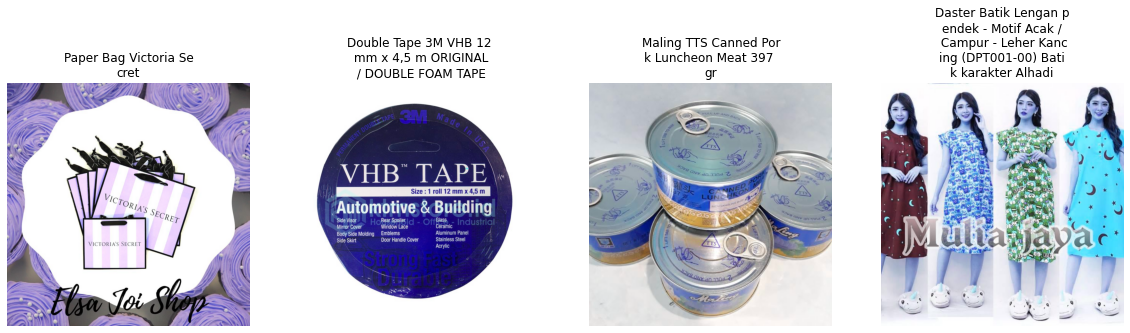

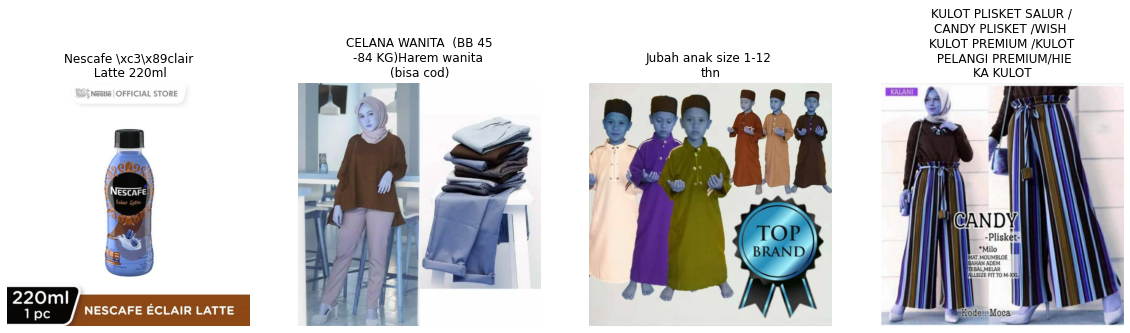

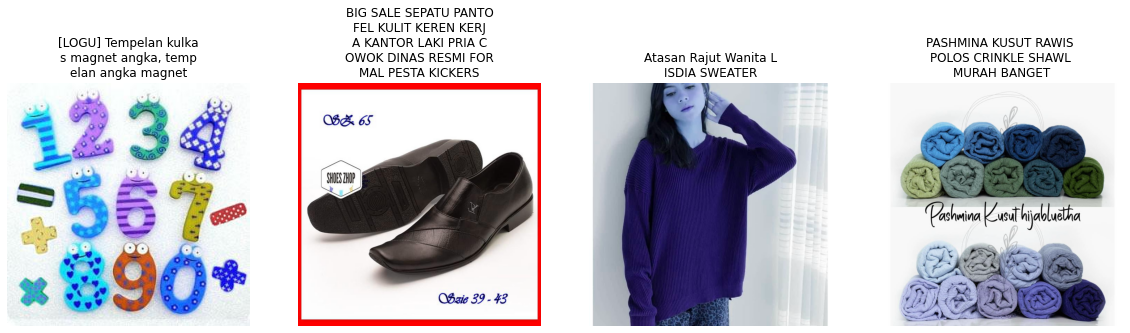

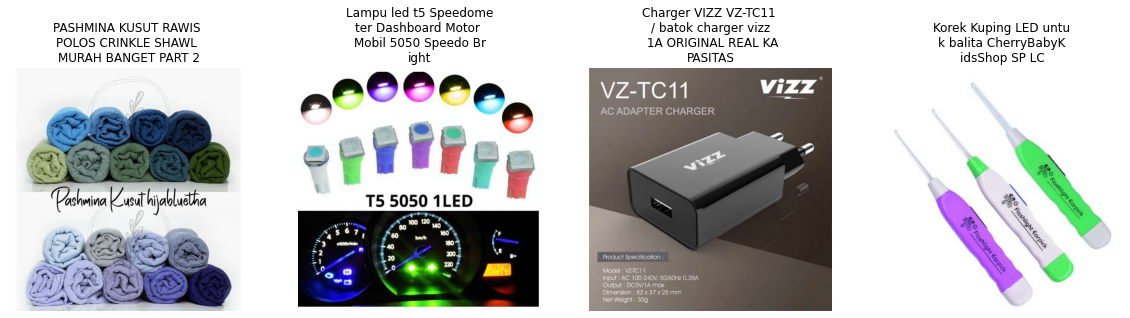

In [5]:
# Print some images
Imagepath = '../input/shopee-product-matching/train_images/'

def displayDF(df, random=False, COLS=4, ROWS=4, path=Imagepath):
    for k in range(ROWS):
        plt.figure(figsize=(20,5))
        for j in range(COLS):
            if random: row = np.random.randint(0,len(df))
            else: row = COLS*k + j
            name = df.iloc[row,1]
            title = df.iloc[row,3]
            title_with_return = ""
            for i,ch in enumerate(title):
                title_with_return += ch
                if (i!=0)&(i%20==0): title_with_return += '\n'
            img = cv2.imread(path+name)
            plt.subplot(1,COLS,j+1)
            plt.title(title_with_return)
            plt.axis('off')
            plt.imshow(img)
        plt.show()
        
displayDF(df,random=False)

In [6]:
# Number of postings grouped by label_group
groupings=df['label_group'].value_counts().reset_index()
groupings.columns=['label_group','count']
groupings['label_group']=groupings['label_group'].astype('str')
groupings.shape

(11014, 2)

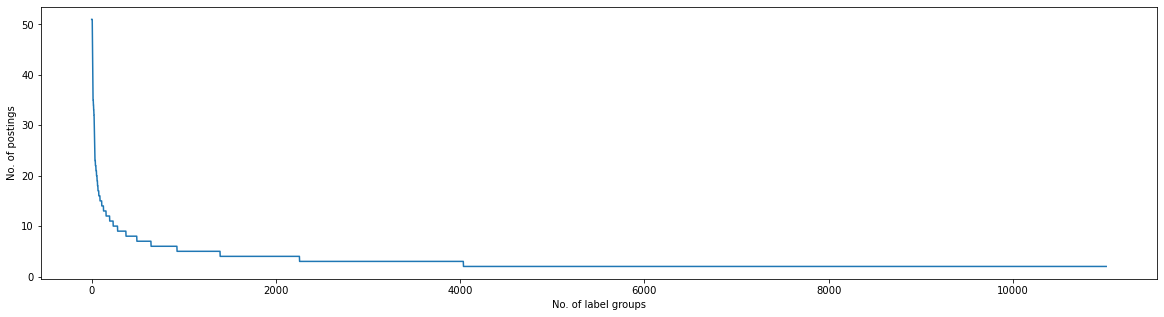

In [7]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(len(groupings)),groupings['count'])
plt.ylabel('No. of postings')
plt.xlabel('No. of label groups')
plt.show()

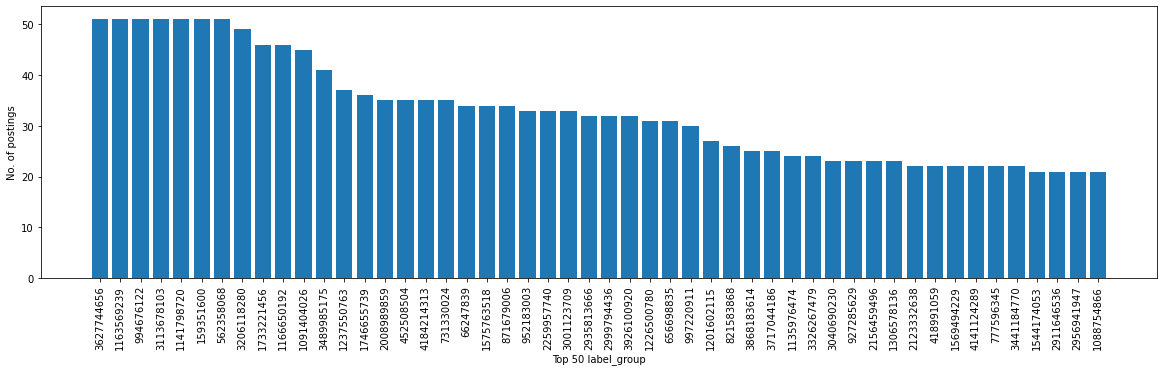

In [8]:
plt.figure(figsize=(20,5))
plt.bar(groupings['label_group'][:50],groupings['count'][:50])
plt.xticks(rotation=90)
plt.xlabel('Top 50 label_group')
plt.ylabel('No. of postings')
plt.show()

label_group : 3627744656


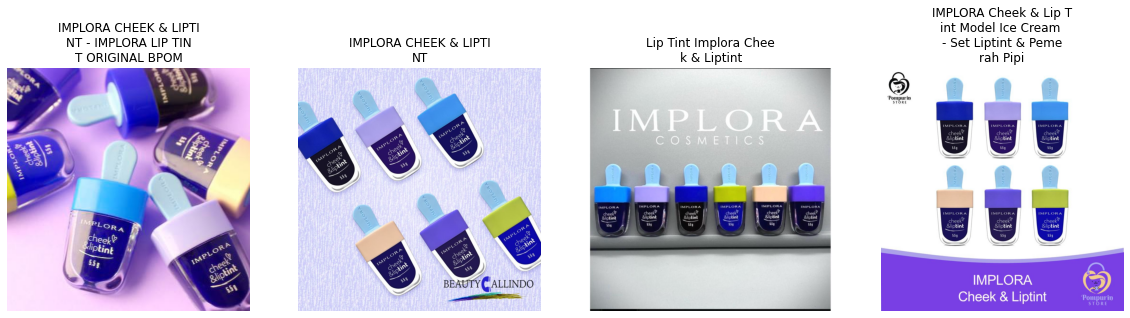

label_group : 1163569239


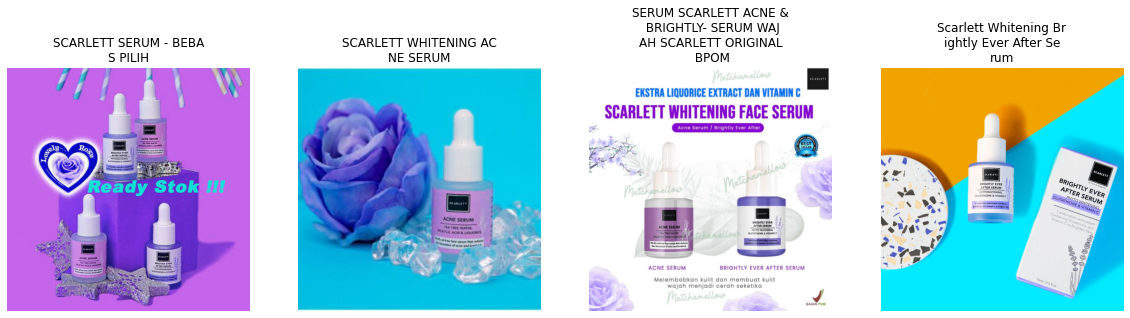

label_group : 994676122


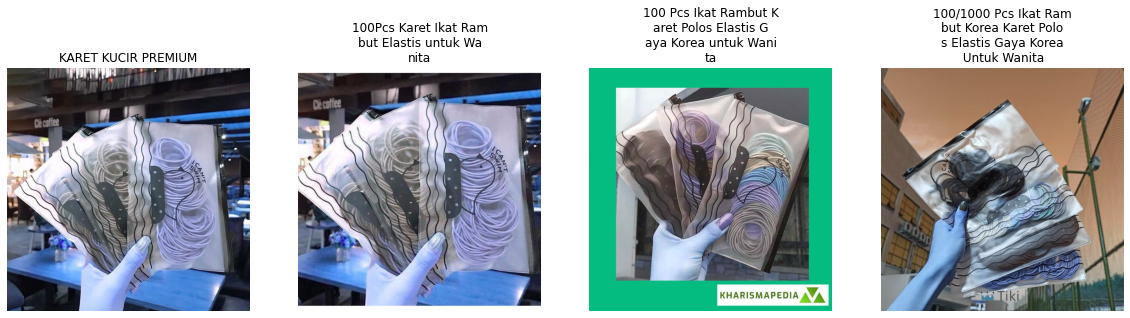

label_group : 3113678103


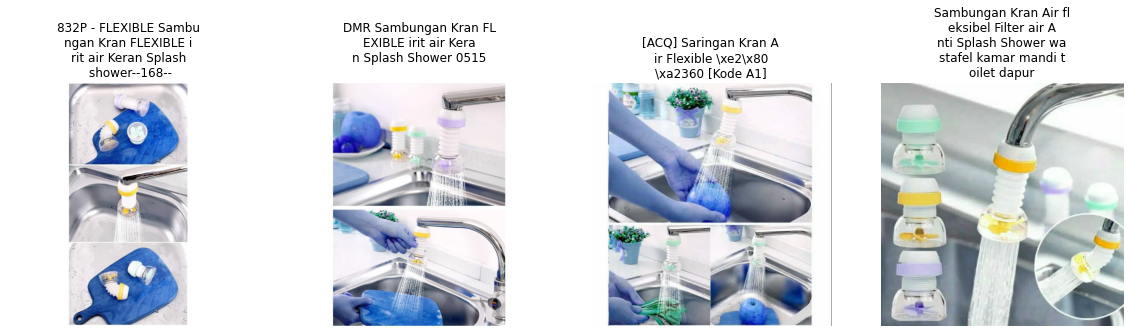

label_group : 1141798720


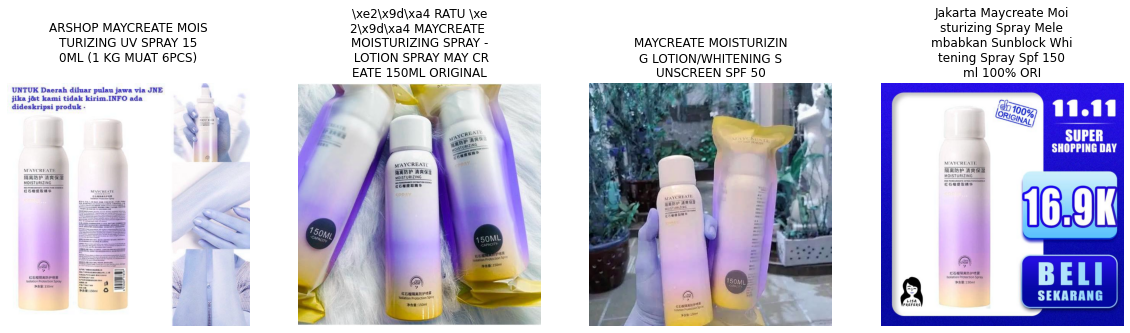

label_group : 159351600


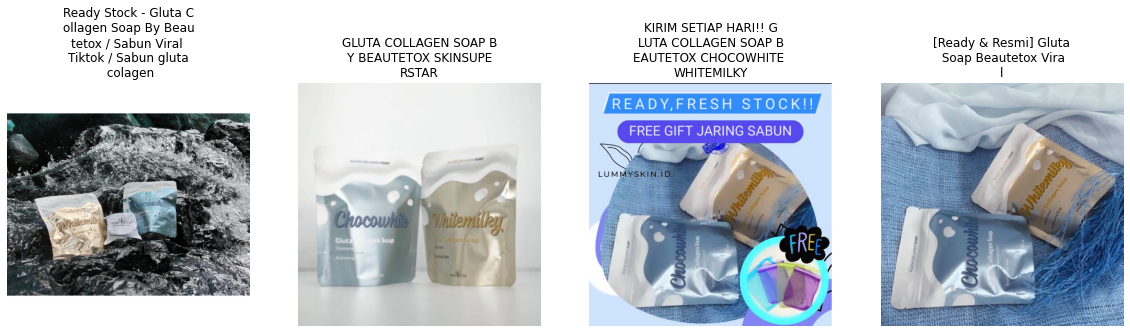

label_group : 562358068


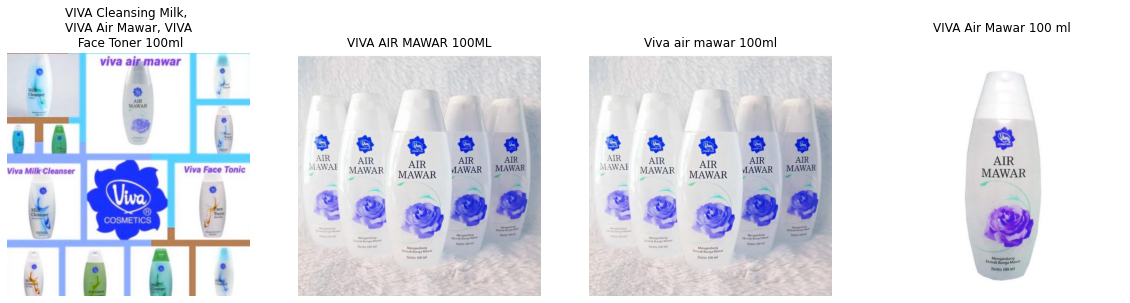

In [9]:
for k in range(7):
    print('label_group :', groupings['label_group'][k])
    top = df.loc[df['label_group']==groupings['label_group'].astype(int)[k]]
    displayDF(top, random=False, ROWS=1, COLS=4)

In [10]:
# Postings with duplicate images
df[df['image'].duplicated()]

posting_id                                 image  \
12     train_2771755203  001e11145b8e9bf5ac51110c0fdd8697.jpg   
29     train_3117535609  00416d439a613fb6cbede5cfc95176e6.jpg   
57      train_615566263  007fca8ce9a042f9e1656ce8f96ba19d.jpg   
59     train_1398921910  0082c9c530852846a5f970ca1b8dc334.jpg   
99     train_1420726013  00d4a4865fa5c81896287fc2c3ea0e1d.jpg   
...                 ...                                   ...   
34103  train_1129868528  fedcf168ed642e9e9277523971f0376a.jpg   
34120  train_1783806612  fef0374b5f70970966a200bc05c44324.jpg   
34190  train_2438146037  ff8c51ae2b910bbd5b185932fafd81d5.jpg   
34225  train_2822476848  ffc7391f30199535379accf6862e1263.jpg   
34243  train_3480437118  ffec72f12011f37a8ade8fc5ec3a571c.jpg   

            image_phash                                              title  \
12     eab5c295966ac368  PASHMINA KUSUT RAWIS POLOS CRINKLE SHAWL MURAH...   
29     bb3fccc4c013c3e1  WINGs BRA-BRA TEMPEL SEAMLESS - PUSH UP BRA - ...   
57     e29b9d52d8a649ac  TUNIK DZUVIA KANCING HIDUP SYARI MOSCREPE PREMIUM   
59     9acce1334ced3a94  TAMBAHAN PACKING KARDUS/BUBBLEWRAP / Centralba...   
99     ee9690c347ceb02e                                  Tzuki Beauty Soap   
...                 ...                                                ...   
34103  beadc0c15e8e6139                 Baso Aci Bandung / Mantaap / Murah   
34120  ab8684078f3dc657  KAPSTOK GANTUNGAN BAJU - KAPSTOK HANDUK KARAKT...   
34190  e4649b9b6d656494  Wardah Nature Daily Orange Pomelo Brightening ...   
34225  a3f27e812323d46d  Sleek Baby Laundry Detergent Botol 1200 ml / S...   
34243  ab37362b173630aa  Johnson\xe2\x80\x99s Top to Toe Hair & Body Ba...   

       label_group  
12       509010932  
29       532279668  
57      1356633425  
59       215542278  
99      3489985175  
...            ...  
34103    209289397  
34120   3416183195  
34190   4230940845  
34225   3725072369  
34243   3561125014  

[1838 rows x 5 columns]

In [11]:
# Select the postings with duplicated images 
duplicated_image=df[df['image'].duplicated(keep=False)].sort_values(by='label_group')
duplicated_image['count']=duplicated_image.groupby(['image'])['image'].transform('count')

In [12]:
# Select the duplicated image name and the duplication count
duplicated=duplicated_image[['image','count']].drop_duplicates().sort_values(by='count',ascending=False)
duplicated

image  count
1658   0cca4afba97e106abd0843ce72881ca4.jpg     15
26628  c739a327dbeca472089a5195e898cce4.jpg     13
19547  9320d7a2181b28e6a61317e8ca06ffea.jpg      9
7378   37c48fec3515e5245dff3dfe268b677b.jpg      9
12610  5ee62d13d49ea74cc3553f8ba5f6220d.jpg      9
...                                     ...    ...
27426  cd4bb44e0dfc394c8cef8dfa2fe1de72.jpg      2
15939  78125afc64af1e69bbb0d1f72525911e.jpg      2
2393   123ed3967260a9d181d2b69709558710.jpg      2
30596  e4c6af1c2f9802bc880fe7cc752afdc5.jpg      2
23954  b37708cc2ff8d5bb0bf872ce8ee51d7c.jpg      2

[1246 rows x 2 columns]

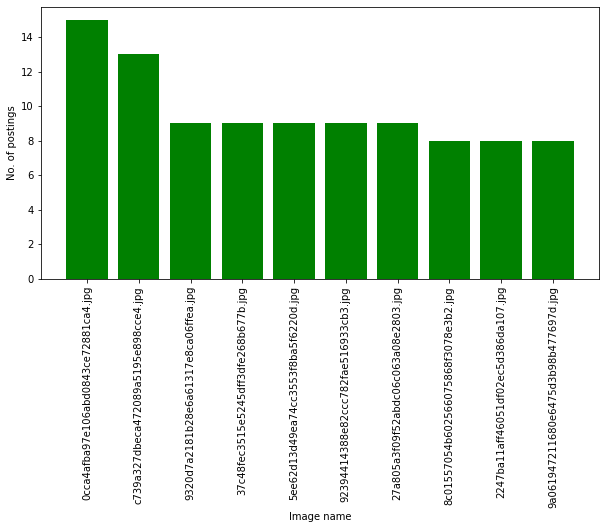

In [13]:
plt.figure(figsize=(10,5))
plt.bar(duplicated['image'][:10],duplicated['count'][:10], color='g')
plt.xticks(rotation=90)
plt.xlabel('Image name')
plt.ylabel('No. of postings')
plt.show()

(array([928., 192.,  60.,  31.,  15.,  10.,   3.,   5.,   0.,   0.,   0.,
          1.,   1.]),
 array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <BarContainer object of 13 artists>)

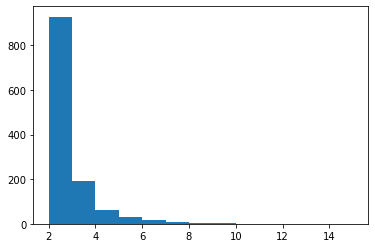

In [14]:
plt.hist(duplicated['count'], bins=np.arange(2,16,1))

(-0.5, 1023.5, 1023.5, -0.5)

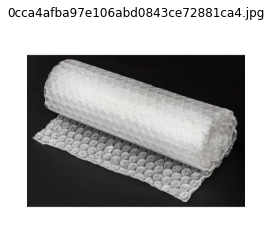

In [15]:
# Show the most used image
img=plt.imread('../input/shopee-product-matching/train_images/' + duplicated['image'].iloc[0])
plt.imshow(img)
plt.title(duplicated['image'].iloc[0])
plt.axis('off')

In [16]:
# Show the postings with the most used image 
duplicated_image[duplicated_image['count']==15]

posting_id                                 image  \
1658  train_4226152332  0cca4afba97e106abd0843ce72881ca4.jpg   
1652  train_1049463374  0cca4afba97e106abd0843ce72881ca4.jpg   
1660  train_3993385953  0cca4afba97e106abd0843ce72881ca4.jpg   
1655   train_443869273  0cca4afba97e106abd0843ce72881ca4.jpg   
1665   train_584097694  0cca4afba97e106abd0843ce72881ca4.jpg   
1659  train_1437764574  0cca4afba97e106abd0843ce72881ca4.jpg   
1661   train_493140267  0cca4afba97e106abd0843ce72881ca4.jpg   
1664  train_2951822530  0cca4afba97e106abd0843ce72881ca4.jpg   
1656  train_1381575164  0cca4afba97e106abd0843ce72881ca4.jpg   
1662   train_419018435  0cca4afba97e106abd0843ce72881ca4.jpg   
1657  train_2085280992  0cca4afba97e106abd0843ce72881ca4.jpg   
1654  train_1236710293  0cca4afba97e106abd0843ce72881ca4.jpg   
1653  train_2420615645  0cca4afba97e106abd0843ce72881ca4.jpg   
1663  train_2514153495  0cca4afba97e106abd0843ce72881ca4.jpg   
1651  train_3068759534  0cca4afba97e106abd0843ce72881ca4.jpg   

           image_phash                                              title  \
1658  d0c0ea37bd9acce0                    EXTRA BUBBLE WRAP UNTUK PACKING   
1652  d0c0ea37bd9acce0                                        BUBBLE WARP   
1660  d0c0ea37bd9acce0               Extra Bubble Wrap Pengaman Packingan   
1655  d0c0ea37bd9acce0                                        Bubble Wrap   
1665  d0c0ea37bd9acce0                           bubble wrap - BUBLE WRAP   
1659  d0c0ea37bd9acce0                                  Extra Bubble Wrap   
1661  d0c0ea37bd9acce0                       PACKING TAMBAHAN BUBBLE WRAP   
1664  d0c0ea37bd9acce0      Tambahan Extra Bubble Wrap Pengaman Packingan   
1656  d0c0ea37bd9acce0                 Bubble Wrap untuk ekstra packaging   
1662  d0c0ea37bd9acce0                               Tambahan Bubble Wrap   
1657  d0c0ea37bd9acce0                                         Buble Wrap   
1654  d0c0ea37bd9acce0                    Bubble Warp Pengaman Pengiriman   
1653  d0c0ea37bd9acce0      BUBBLE WRAP - EXTRA PACKING UNTUK BARANG ANDA   
1663  d0c0ea37bd9acce0  Tambahan Bubble wrap / Plastik Bubble Pelindun...   
1651  d0c0ea37bd9acce0  BUBBLE PACK UNTUK PACKING TAMBAHAN 1BUBBLE UNT...   

      label_group  count  
1658   2403374241     15  
1652   2403374241     15  
1660   2403374241     15  
1655   4198148727     15  
1665   4198148727     15  
1659   4198148727     15  
1661   4198148727     15  
1664   4198148727     15  
1656   4198148727     15  
1662   4198148727     15  
1657   4198148727     15  
1654   4198148727     15  
1653   4198148727     15  
1663   4198148727     15  
1651   4198148727     15

### NLP Based EDA

In [17]:
# Cleanup tile
def clean(title):
    sw=stopwords.words('english')
    title=title.lower()
    title=[x for x in title.split() if not x in sw]
    title=' '.join(title)
    title=re.sub(r'[^\w\s]','',title)
    return title
df['clean_title']=df['title'].apply(clean)
df['title_length']=df['clean_title'].str.split().str.len()
df

posting_id                                 image  \
0       train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg   
1      train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg   
2      train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg   
3      train_2406599165  00117e4fc239b1b641ff08340b429633.jpg   
4      train_3369186413  00136d1cf4edede0203f32f05f660588.jpg   
...                 ...                                   ...   
34245  train_4028265689  fff1c07ceefc2c970a7964cfb81981c5.jpg   
34246   train_769054909  fff401691371bdcb382a0d9075dfea6a.jpg   
34247   train_614977732  fff421b78fa7284284724baf249f522e.jpg   
34248  train_3630949769  fff51b87916dbfb6d0f8faa01bee67b8.jpg   
34249  train_1792180725  ffffa0ab2ae542357671e96254fa7167.jpg   

            image_phash                                              title  \
0      94974f937d4c2433                          Paper Bag Victoria Secret   
1      af3f9460c2838f0f  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   
2      b94cb00ed3e50f78        Maling TTS Canned Pork Luncheon Meat 397 gr   
3      8514fc58eafea283  Daster Batik Lengan pendek - Motif Acak / Camp...   
4      a6f319f924ad708c                  Nescafe \xc3\x89clair Latte 220ml   
...                 ...                                                ...   
34245  e3cd72389f248f21  Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...   
34246  be86851f72e2853c    MamyPoko Pants Royal Soft - S 70 - Popok Celana   
34247  ad27f0d08c0fcbf0  KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...   
34248  e3b13bd1d896c05c  Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...   
34249  af8bc4b2d2cf9083  FLEX TAPE PELAPIS BOCOR / ISOLASI AJAIB / ANTI...   

       label_group                                        clean_title  \
0        249114794                          paper bag victoria secret   
1       2937985045  double tape 3m vhb 12 mm x 45 original  double...   
2       2395904891        maling tts canned pork luncheon meat 397 gr   
3       4093212188  daster batik lengan pendek  motif acak  campur...   
4       3648931069                    nescafe xc3x89clair latte 220ml   
...            ...                                                ...   
34245   3776555725  masker bahan kain spunbond non woven 75 gsm 3 ...   
34246   2736479533        mamypoko pants royal soft  70  popok celana   
34247   4101248785  khanzaacc robot re101s 12mm subwoofer bass met...   
34248   1663538013  kaldu non msg halal mama kamu ayam kampung  sa...   
34249    459464107  flex tape pelapis bocor  isolasi ajaib  anti b...   

       title_length  
0                 4  
1                12  
2                 8  
3                13  
4                 4  
...             ...  
34245            13  
34246             7  
34247             9  
34248            14  
34249             8  

[34250 rows x 7 columns]

In [18]:
df['title_length'].value_counts()

6     3690
7     3657
5     3317
8     3307
9     3028
10    2705
4     2392
11    2356
12    1999
13    1691
14    1478
3     1306
15    1172
16     686
2      521
17     350
18     164
19      85
1       52
21      49
20      45
22      31
24      26
23      21
25      19
26      14
29      14
28       8
32       8
27       7
30       6
31       5
42       5
34       4
37       4
38       3
35       3
57       2
33       2
60       2
59       2
45       2
43       2
36       2
44       1
58       1
54       1
39       1
53       1
40       1
61       1
50       1
Name: title_length, dtype: int64

<AxesSubplot:xlabel='title_length', ylabel='Count'>

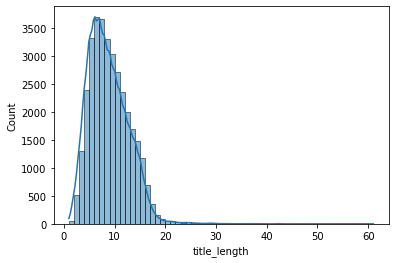

In [19]:
sns.histplot(df['title_length'], binwidth=1, kde=True)

<AxesSubplot:>

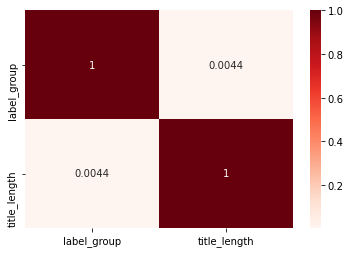

In [20]:
sns.heatmap(df.corr(method='pearson'), annot = True, cmap="Reds")

In [21]:
# Tokenize the title
token_text=''
for i in tqdm(df['clean_title']):
    token_l=i.split()
    token_text+=' '.join(token_l) + ' ' 

  0%|          | 0/34250 [00:00<?, ?it/s]

### WordCloud for Title Text

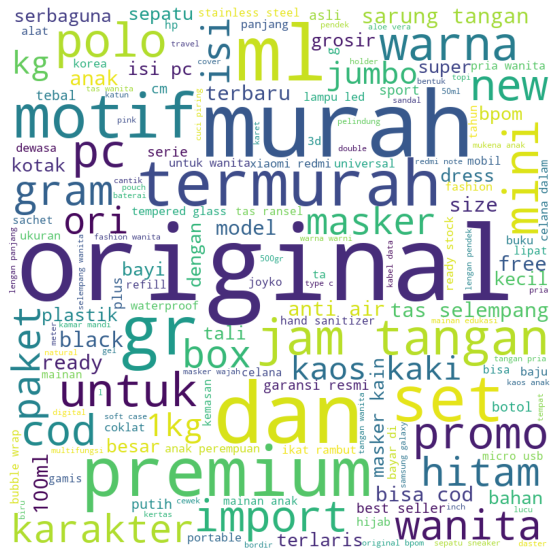

In [22]:
wordcloud=WordCloud(width=800, height=800, background_color='white', min_font_size = 10).generate(token_text)
plt.figure(figsize=(10, 10)) 
plt.imshow(wordcloud) 
plt.axis("off")
plt.show() 

In [23]:
from PIL import Image
cart_mask=np.array(Image.open('../input/cart-image/cart-icon.jpeg'))

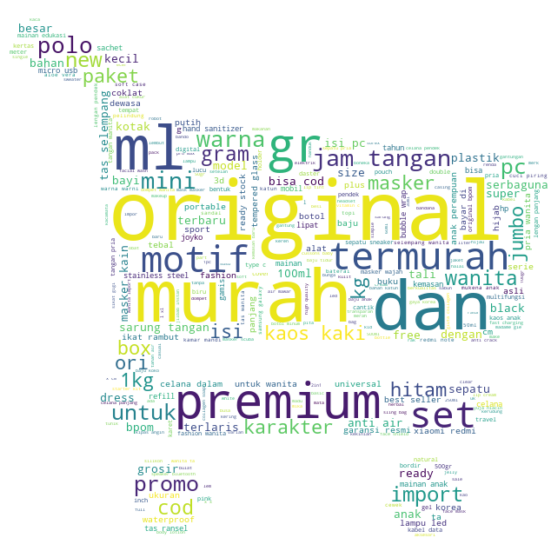

In [24]:
wordcloud2=WordCloud(width=1000, height=1000, background_color='white', max_words=3000, mask=cart_mask).generate(token_text)
plt.figure(figsize=(10, 10)) 
plt.imshow(wordcloud2, interpolation='bilinear') 
plt.axis("off") 
plt.show() 